## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)


## Introduction: Business Problem <a name="introduction"></a>

In this project, I am trying to find best reataurant to eat chicken biryani for a person who came to Banglore for the first time and staying in a Hotel within 5 km range from his location. This project is also targeting the people those want to know the best biryani point in their areas.

As there may be many restaurants within 5 km range so it's difficult to say which one is serving best biryani.

To solve this problem I will use the magic of Data Science.

## Data <a name="data"></a>

To solve this problem  I required following data about restaurants within 5 km range from the user's location :

* wheather the restaurant serves biryani or not.
* rating of restaurant from online plateforms.
* coordinate's location of restaurant to showing the path on map to the restaurant from user's location.
* user's coordinates location.
* travel time to restaurants from user's location.
* travel distance betweent restaurant and user's location.

Following data sources will be needed to extract/generate the required information:

* **geopy libray** to get coordinate's location of User.
* **foursqaue API** to explorer user's location to get list of nearby restaurants.
* **zomato API** to get ratings of restaurants.   
(I am using zomato api for ratings because zomato is more used here in Hyderabad than foursquare)
* **bing map API** to get driving path locations.

**Note**
* I will only select first 100 restaurants with in 5 km range for this project.
* I will use manual searching for getting whether a restaurant serves biryani or not because these restaurants's food menu data is not available in zomato api, foursquare api and uber eat api so I have no option. 

In [69]:
# installing required libraries

!pip install geopy # Installing geopy library, this library helps in getting Latitude and Longitude of a given address.
!pip install folium # map visualizing library. 

#avoiding warnigs
pd.options.mode.chained_assignment = None # avoiding setting with copy warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [70]:
#importing required libraries

import pandas as pd
import numpy as np
import requests
import folium
from geopy.geocoders import Nominatim # Nominatim converts an address into latitude and longitude values.


In [71]:
#Getting Location's Coordinates of Bangalore City.......

address = 'Bangalore'
geolocator = Nominatim(user_agent='Bangalore_explorer')
Bng_location = geolocator.geocode(address)
Bng_latitude = Bng_location.latitude
Bng_longitude = Bng_location.longitude
print('latitide=',Bng_latitude,' longitude=',Bng_longitude)

latitide= 12.9791198  longitude= 77.5912997


In [72]:
#Getting Hotel location where user stay...
# I am considering that for this project, user stay in The Park Bangalore
Hotel_address = 'The Park Bangalore'
B_location = geolocator.geocode(Hotel_address)
B_lat = B_location.latitude
B_long = B_location.longitude
print('latitude=',B_lat,' longitude=',B_long)

latitude= 12.9791198  longitude= 77.5912997


In [73]:
# defining forsquare credentials to get list of 100 restaurants near by user's location.

LIMIT = 100 # no. of restaurants.
radius = 6000 # defing range 6 KM, I am considering range+1.
CLIENT_ID = 'enter your id' # my Foursquare ID
CLIENT_SECRET = 'enter your id' # my Foursquare Secret
VERSION = '20180605' # Foursquare API version

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    H_lat, 
    H_long, 
    radius, 
    LIMIT)

url 

'https://api.foursquare.com/v2/venues/explore?&client_id=R2BIIT34OF4G1EEVQ3KOAVQKTISEEUOFYTDYKGYRYA2KDVBG&client_secret=SVI5B3EYUOX2W0VOR1A10OWPP2TSMUKLL4TG544I3MMA1G5L&v=20180605&ll=12.9791198,77.5912997&radius=6000&limit=100'

In [74]:
# API calling to get data in Json format

result = requests.get(url).json()
result

{'meta': {'code': 200, 'requestId': '5f54ee244f3e540acf9322b4'},
 'response': {'groups': [{'items': [{'reasons': {'count': 0,
       'items': [{'reasonName': 'globalInteractionReason',
         'summary': 'This spot is popular',
         'type': 'general'}]},
      'referralId': 'e-0-4bbc4513e45295217db855a4-0',
      'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/park_',
          'suffix': '.png'},
         'id': '4bf58dd8d48988d163941735',
         'name': 'Park',
         'pluralName': 'Parks',
         'primary': True,
         'shortName': 'Park'}],
       'id': '4bbc4513e45295217db855a4',
       'location': {'address': 'M G Road',
        'cc': 'IN',
        'city': 'Bangalore',
        'country': 'India',
        'distance': 489,
        'formattedAddress': ['M G Road', 'Bangalore', 'Karnātaka', 'India'],
        'labeledLatLngs': [{'label': 'display',
          'lat': 12.977042175203783,
          'lng': 77.59527683258057}],

In [75]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [76]:
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

restaurants = result['response']['groups'][0]['items']
    
nearby_restaurants = json_normalize(restaurants) # flatten JSON

# filter columns
filtered_columns = ['venue.name','venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_restaurants = nearby_restaurants.loc[:, filtered_columns]

# filter the category for each row
nearby_restaurants['venue.categories'] = nearby_restaurants.apply(get_category_type, axis=1)

# clean columns
nearby_restaurants.columns = [col.split(".")[-1] for col in nearby_restaurants.columns]

nearby_restaurants.head()

,name,categories,lat,lng
0,Cubbon Park,Park,12.977042,77.595277
1,JW Marriott Hotel Bengaluru,Hotel,12.972362,77.595051
2,Taj West End,Hotel,12.984572,77.584893
3,UB City,Shopping Mall,12.971709,77.595905
4,Smoke House Deli,Deli / Bodega,12.971656,77.598254


In [77]:
# getting ratings of restaurants from zomato

rating=[] #list to store rating
zomato_key = {'user-key':'enter your key'} # zomato api key
count = 1 # counter

print('Processing restaurant no: ')
for name,lat,lng in zip(nearby_restaurants['name'],nearby_restaurants['lat'],nearby_restaurants['lng']):
    print(count,end=" ")
    url = ('https://developers.zomato.com/api/v2.1/search?q={}&start=0&count=1&lat={}&lon={}').format(name,lat,lng)
    result = requests.get(url, headers = zomato_key)
    if(result.status_code == 200):
        try:
            result = result.json()
            rating.append(result['restaurants'][0]['restaurant']['user_rating']['aggregate_rating'])
        except:
            rating.append('NA')
    else:
        rating.append('NA')
    count+=1

print('\n restaurants ratings are : ')
print(rating)

Processing restaurant no: 
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
 restaurants ratings are : 
['4.3', '4.6', '4.4', '4.5', '4.5', '3.5', '4.2', '4.3', '4.3', '4.4', '3.4', '3.7', '4.4', '4.6', '4.4', '4.4', '4.2', '4.3', '4.6', 'NA', '4.0', '3.9', '4.3', '3.8', '4.3', '4.3', '4.6', '4.2', '4.7', '4.2', '4.1', '4.4', '3.7', '4.4', '4.4', '4.2', '4.5', '4.2', '4.3', '4.5', '4.2', '4.1', '4.3', '4.4', '4.5', 'NA', '4.3', '3.9', '3.6', '4.1', '4.5', '4.0', '4.3', '4.4', '4.2', '4.1', '4.0', '4.7', '4.0', '4.1', '4.4', '4.7', '3.8', '3.8', '4.3', '4.1', 'NA', '4.2', '4.2', '4.9', '4.0', '4.7', '4.2', '4.7', '4.1', '4.1', '4.4', '4.1', '4.2', '4.3', '4.6', '4.4', '4.5', 0, '4.2', '2.9', '3.8', '4.5', '3.8', '4.1', '4.2', '4.6', '3.8', '4.9', 

In [78]:
# adding ratings

nearby_restaurants['zomato rating'] = rating
nearby_restaurants.head()

,name,categories,lat,lng,zomato rating
0,Cubbon Park,Park,12.977042,77.595277,4.3
1,JW Marriott Hotel Bengaluru,Hotel,12.972362,77.595051,4.6
2,Taj West End,Hotel,12.984572,77.584893,4.4
3,UB City,Shopping Mall,12.971709,77.595905,4.5
4,Smoke House Deli,Deli / Bodega,12.971656,77.598254,4.5


In [79]:
# checking restaurants who have no ratings

nearby_restaurants[nearby_restaurants['zomato rating']=='NA'].index

Int64Index([19, 45, 66], dtype='int64')

In [80]:
# droping the restaurants from list

nearby_restaurants.drop([19, 45, 66],axis=0,inplace=True)
nearby_restaurants.head()

,name,categories,lat,lng,zomato rating
0,Cubbon Park,Park,12.977042,77.595277,4.3
1,JW Marriott Hotel Bengaluru,Hotel,12.972362,77.595051,4.6
2,Taj West End,Hotel,12.984572,77.584893,4.4
3,UB City,Shopping Mall,12.971709,77.595905,4.5
4,Smoke House Deli,Deli / Bodega,12.971656,77.598254,4.5


In [81]:
# getting travel distance and travel time

from datetime import datetime
start_time = datetime.now(tz=None)

time=[] # time unit: minutes
distance=[] # distance unit: km

key = 'enter your key' # Bing Map Api Key.
count = 1 # counter.

print('Processing restaurant no: ')
for name,lat,lng in zip(nearby_restaurants['name'],nearby_restaurants['lat'],nearby_restaurants['lng']):
    url = 'https://dev.virtualearth.net/REST/v1/Routes/DistanceMatrix?origins={},{}&destinations={},{}&travelMode=driving&startTime={}&key={}'.format(
                                                                                                                                                H_lat,
                                                                                                                                                H_long,
                                                                                                                                                lat,
                                                                                                                                                lng,
                                                                                                                                                start_time,
                                                                                                                                                key)
    print(count,end=" ")
    result = requests.get(url).json()
    time.append(result['resourceSets'][0]['resources'][0]['results'][0]['travelDuration'])
    distance.append(result['resourceSets'][0]['resources'][0]['results'][0]['travelDistance'])
    count+=1
print('\n time list : ')
print(time)
print('\n distance list')
print(distance)

Processing restaurant no: 
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 
 time list : 
[14.5, 13.25, 7.333, 11.75, 14.667, 11.4, 13.25, 8.5, 13.25, 14.9, 13.25, 15.133, 13.25, 14.45, 13.933, 11.6, 14.133, 7.333, 7.983, 14.667, 17.817, 17.75, 12.35, 15.433, 19.133, 9.467, 6.95, 15.133, 5.283, 8.267, 8.533, 13.267, 13.133, 12.367, 18.3, 8.667, 18.3, -1, 18.3, 17.25, 11.9, 19.767, 21.717, 19.833, 19.933, 19.767, 17.25, 19.45, 11.717, 19.1, 22.7, 17.1, 19.1, 8.033, 11.383, 15.95, 20.867, 15.683, 17.417, 17.8, 17.167, 20.35, 7.633, 14.583, 17.75, 20.517, 22.1, 18.283, 15.55, 25.25, 20.35, 22.417, 22.783, 17.75, 20.35, 16.433, 21.733, 22.983, 19.65, 22.533, 14.25, 25.25, 17.85, 20.1, 20.667, 20.35, 21.117, 20.417, 21.133, 20.35, 23.733, 14.583, 22.167, 24.6, 

In [84]:
# adding time, distance and serving biryani data to our dataframe

nearby_restaurants['travel time minutes'] = time
nearby_restaurants['travel distance km'] = distance

serving_biryani = [1,0,0,1,1,0,1,0,0,1,1,0,0,1,
                   1,0,0,1,1,0,1,0,1,0,0,0,1,1,
                   0,1,1,0,0,1,0,0,0,0,0,0,0,0,
                   0,1,0,1,0,0,0,0,0,0,0,0,0,1,
                   0,0,1,1,1,0,0,0,0,0,0,0,0,0,
                   1,0,0,0,0,1,1,0,0,0,0,0,0,1,
                   0,0,0,0,0,0,0,0,0,0,0,0,0,] # menually generated list from online searching -> 1: yes, 0: no

nearby_restaurants['serves biryani'] = serving_biryani

nearby_restaurants.head()

,name,categories,lat,lng,zomato rating,travel time minutes,travel distance km,serves biryani
0,Cubbon Park,Park,12.977042,77.595277,4.3,14.500,3.995,1
1,JW Marriott Hotel Bengaluru,Hotel,12.972362,77.595051,4.6,13.250,3.083,0
2,Taj West End,Hotel,12.984572,77.584893,4.4,7.333,2.106,0
3,UB City,Shopping Mall,12.971709,77.595905,4.5,11.750,3.082,1
4,Smoke House Deli,Deli / Bodega,12.971656,77.598254,4.5,14.667,3.744,1


In [85]:
# getting those restaurants who serves biryani

biryani_points = nearby_restaurants[nearby_restaurants['serves biryani']==1].reset_index(drop=True)
biryani_points.head()

,name,categories,lat,lng,zomato rating,travel time minutes,travel distance km,serves biryani
0,Cubbon Park,Park,12.977042,77.595277,4.3,14.500,3.995,1
1,UB City,Shopping Mall,12.971709,77.595905,4.5,11.750,3.082,1
2,Smoke House Deli,Deli / Bodega,12.971656,77.598254,4.5,14.667,3.744,1
3,Shiro,Japanese Restaurant,12.971900,77.596236,4.2,13.250,3.212,1
4,Hard Rock Cafe Bengaluru,American Restaurant,12.976389,77.601468,4.4,14.900,3.544,1


In [86]:
biryani_points.shape

(27, 8)

There are 27 restaurants who serves biryani near by user's location

#### Our Data aquisition and data preprocessing has completed now next some visulizations.

### Bangalore City Map

In [88]:
import folium

Bng_map = folium.Map( location=[Bng_latitude,Bng_longitude], zoom_start=12)
Bng_map

### Get user's location on map

In [89]:
Bng_map = folium.Map(location=[B_lat,B_long],zoom_start=20)
folium.Marker(location=[B_lat,B_long],tooltip='The Park Bangalore').add_to(Bng_map)
Bng_map

### Showing all restaurants on map those serve biryani 

In [90]:
Bng_map = folium.Map(location=[B_lat,B_long],zoom_start=13)
folium.Marker(location=[B_lat,B_long],tooltip='The Park Bangalore').add_to(Bng_map)

for name,lat,lng in zip(biryani_points['name'],biryani_points['lat'],biryani_points['lng']):
    folium.CircleMarker(
                         location=[lat,lng],
                         tooltip=name,
                         color='blue',
                         radius=6,
                         fill=True,
                         fill_color='red',
                         fill_opacity=0.8).add_to(Bng_map)
Bng_map

## Methodology <a name="methodology"></a>

To find the best biryani serving restaurant near the user's location, First I have to check those restaurants with highest rating so need to sort our data in descending order according to rating to get highest rating restaurants on top of the list then I will consider only those restaurants having high value rating then after I will sort restaurants list according to travel time in ascending order to get a restaurant where user can reach in short time and for result I will select the first restaurant in the list after doing all anaysis.

To solve this problem I don't require any machine learning algorithm.

In [91]:
biryani_points['zomato rating'] = biryani_points['zomato rating'].astype(float)

In [92]:
# Sorting data Frame according to zomato ratings in descending order.

biryani_points.sort_values(by='zomato rating',ascending=False,inplace=True)
biryani_points.reset_index(drop=True,inplace=True)
biryani_points.head()

,name,categories,lat,lng,zomato rating,travel time minutes,travel distance km,serves biryani
0,Natural Ice Cream,Ice Cream Shop,12.971378,77.600989,4.7,15.133,3.920,1
1,Yauatcha,Asian Restaurant,12.973318,77.620072,4.7,20.350,5.479,1
2,Shri Sagar (Formerly CTR),Indian Restaurant,12.998309,77.569460,4.7,17.800,4.411,1
3,Mavalli Tiffin Room (MTR),Indian Restaurant,12.955122,77.585552,4.7,15.950,4.477,1
4,Corner House,Ice Cream Shop,12.972979,77.599971,4.6,14.450,3.641,1


In [93]:
# Getting list of highest rating restaurants.

top_points = biryani_points[biryani_points['zomato rating']==biryani_points['zomato rating'][0]]
top_points

,name,categories,lat,lng,zomato rating,travel time minutes,travel distance km,serves biryani
0,Natural Ice Cream,Ice Cream Shop,12.971378,77.600989,4.7,15.133,3.920,1
1,Yauatcha,Asian Restaurant,12.973318,77.620072,4.7,20.350,5.479,1
2,Shri Sagar (Formerly CTR),Indian Restaurant,12.998309,77.569460,4.7,17.800,4.411,1
3,Mavalli Tiffin Room (MTR),Indian Restaurant,12.955122,77.585552,4.7,15.950,4.477,1


Next step is for the situation if I get more than one restaurant with rating 4.7 so there is need to choose one and for this I am choosing that restaurant where user can reach in short time.

In [94]:
# sorting the dataframe according to travel time in ascending order..

top_points.sort_values(by=['travel time minutes'],inplace=True) # sorting list according to time.
top_points.reset_index(drop=True, inplace=True)
top_points = top_points[top_points['travel distance km']<=5].reset_index(drop=True) # considering only restaurants those are in 5 km range.
top_points

,name,categories,lat,lng,zomato rating,travel time minutes,travel distance km,serves biryani
0,Natural Ice Cream,Ice Cream Shop,12.971378,77.600989,4.7,15.133,3.920,1
1,Mavalli Tiffin Room (MTR),Indian Restaurant,12.955122,77.585552,4.7,15.950,4.477,1
2,Shri Sagar (Formerly CTR),Indian Restaurant,12.998309,77.569460,4.7,17.800,4.411,1


Let's do some analysis now..

## Analysis <a name="analysis"></a>

**Doing some additional analysis on fetched data..**

**Let's check how many different catagories of restaurants are near by the user's location**

In [95]:
len(nearby_restaurants['categories'].unique())

49

There are 47 different catagories of restaurants.

**Let's check how many restaurants are there in each catagory..**

In [96]:
category = nearby_restaurants['categories'].unique().tolist()
category[0:10]

['Park',
 'Hotel',
 'Shopping Mall',
 'Deli / Bodega',
 'Cricket Ground',
 'Japanese Restaurant',
 'Tea Room',
 'French Restaurant',
 'American Restaurant',
 'Lounge']

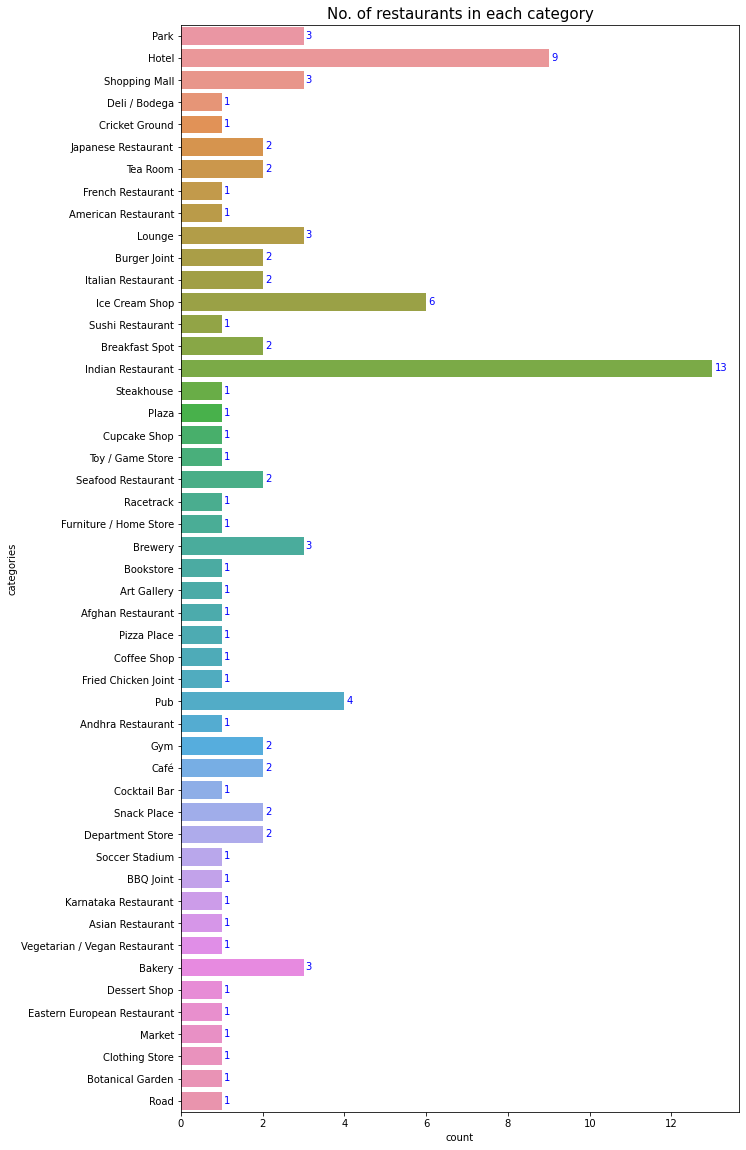

In [97]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,20))
ax = sns.countplot(y='categories', data=nearby_restaurants)
y_count=0.1
for p in ax.patches:
    ax.annotate(str(p.get_width()), (p.get_width()+0.05,y_count),color='blue')
    y_count+=1
plt.title('No. of restaurants in each category',size=15)
plt.show()

Mostly there are one or two restaurant in each catagory except Indian Restaurants, South Indian, cafe and Bakery.

**Let's check different catagories of restaurants those serve biryani**

In [98]:
biryani_points.categories.unique()

array(['Ice Cream Shop', 'Asian Restaurant', 'Indian Restaurant',
       'Steakhouse', 'Deli / Bodega', 'Andhra Restaurant',
       'Shopping Mall', 'Hotel', 'American Restaurant',
       'Sushi Restaurant', 'Snack Place', 'Burger Joint', 'Bakery',
       'Park', 'Seafood Restaurant', 'Vegetarian / Vegan Restaurant',
       'Japanese Restaurant', 'Gym', 'Plaza', 'Cupcake Shop', 'Café',
       'Lounge'], dtype=object)

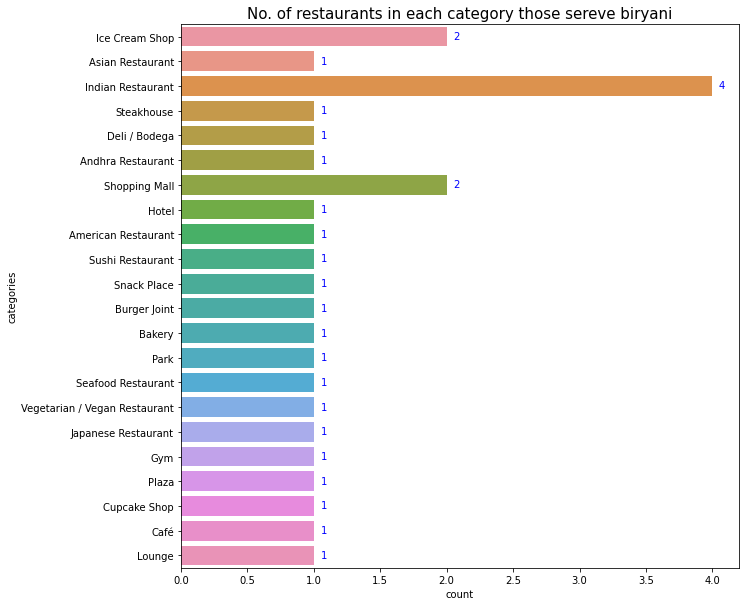

In [99]:
plt.figure(figsize=(10,10))
ax = sns.countplot(y='categories', data=biryani_points)
y_count=0.1
for p in ax.patches:
    ax.annotate(str(p.get_width()), (p.get_width()+0.05,y_count),color='blue')
    y_count+=1
plt.title('No. of restaurants in each category those sereve biryani',size=15)
plt.show()

**Let's look out on ratings**

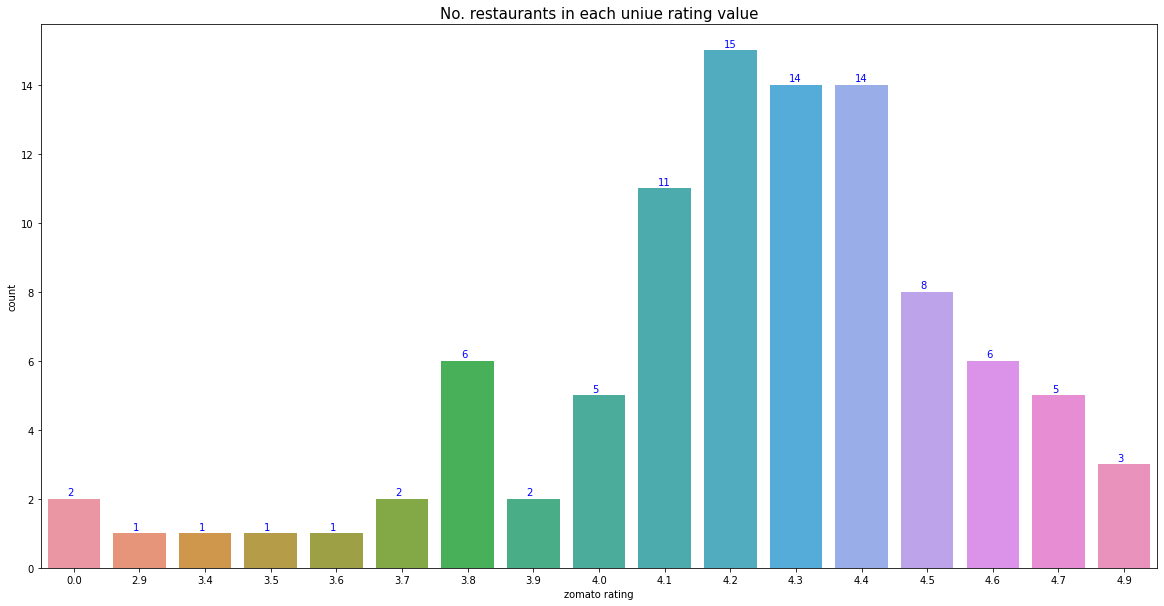

In [100]:
nearby_restaurants['zomato rating'] = nearby_restaurants['zomato rating'].astype(float)
plt.figure(figsize=(20,10))
ax = sns.countplot(x='zomato rating', data=nearby_restaurants)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()+0.3,p.get_height()+0.1),color='blue')
plt.title('No. restaurants in each uniue rating value', size=15)
plt.show()

Mostly restaurants have ratings between 4 and 4.6. There is only one restaurant with rating of 4.8

**Let's checkout those restaurant's ratings who serve biryani**

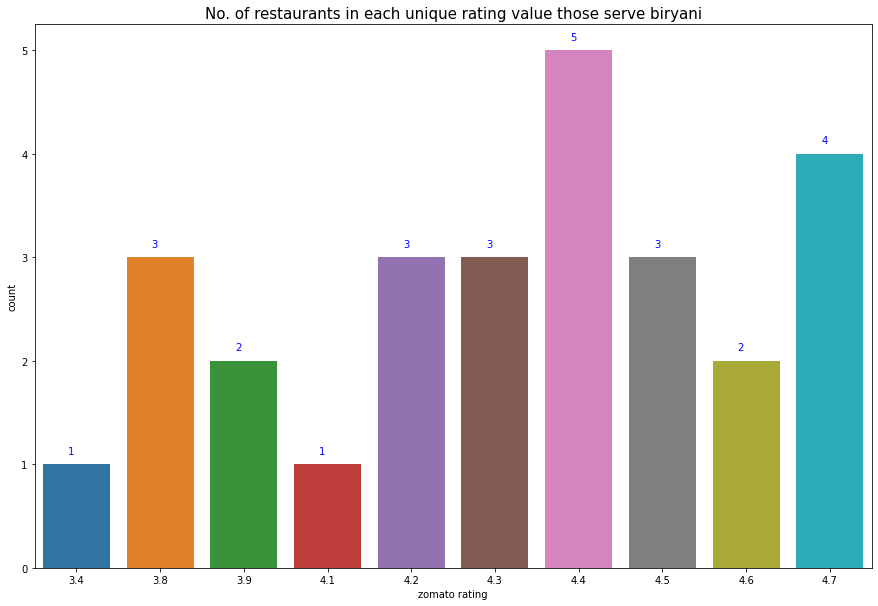

In [101]:
plt.figure(figsize=(15,10))
ax = sns.countplot(x='zomato rating', data=biryani_points)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()+0.3,p.get_height()+0.1),color='blue')
plt.title('No. of restaurants in each unique rating value those serve biryani', size=15)
plt.show()

There is only one restaurant with rating of 4.6...

## Results and Discussion <a name="results"></a>

In methodology section I have already computed the list of highest rating restaurants those serves biryani so for the result it's better to select the restaurant having highest rating as well as less time is require to travel from user's location to restaurant.

In [102]:
print('best biryani points with in 5 km is ',top_points.iloc[0]['name'])
print('Distance =',top_points.iloc[0]['travel distance km'],'KM')
print('Travel Time =',round(top_points.iloc[0]['travel time minutes']),'Minutes')

best biryani points with in 5 km is  Natural Ice Cream
Distance = 3.92 KM
Travel Time = 15.0 Minutes


In [103]:
# getting coordinate's location of best biryani point

BP_lat = top_points.iloc[0]['lat']
BP_lng = top_points.iloc[0]['lng']
print('latitude =',BP_lat,' longitude =',BP_lng)

latitude = 12.971377630166776  longitude = 77.60098865044374


In [104]:
# generating url to fectch path data from user's location to retaurant'S location

bing_key = 'enter your key'

url='http://dev.virtualearth.net/REST/V1/Routes/Driving?wp.0={},{}&wp.1={},{}&optmz=distance&routeAttributes=routePath&key={}'.format(H_lat,
                                                                                                                                      H_long,
                                                                                                                                      BP_lat,
                                                                                                                                      BP_lng,
                                                                                                                                      bing_key)
print(url)

http://dev.virtualearth.net/REST/V1/Routes/Driving?wp.0=12.9791198,77.5912997&wp.1=12.971377630166776,77.60098865044374&optmz=distance&routeAttributes=routePath&key=AlJn95sso21iAFGdv4DKD9oO-6zb69vO0k3IHt6qIfpHFGVlIED4Mfu1i_Pbqytj


In [105]:
# fetching data

result = requests.get(url).json()
result

{'authenticationResultCode': 'ValidCredentials',
 'brandLogoUri': 'http://dev.virtualearth.net/Branding/logo_powered_by.png',
 'copyright': 'Copyright © 2020 Microsoft and its suppliers. All rights reserved. This API cannot be accessed and the content and any results may not be used, reproduced or transmitted in any manner without express written permission from Microsoft Corporation.',
 'resourceSets': [{'estimatedTotal': 1,
   'resources': [{'__type': 'Route:http://schemas.microsoft.com/search/local/ws/rest/v1',
     'bbox': [12.971317, 77.588768, 12.984258, 77.601251],
     'distanceUnit': 'Kilometer',
     'durationUnit': 'Second',
     'id': 'v70,h-509685098,i0,a0,cen-US,dAAAAAAAAAAA1,y0,s1,m1,o2,t4,wbLu_ME_1KUCdaLLa12VTQA2~AJI6cGdRpxp_AADgAal7kz4A0~cm9hZA2~~~~v11,wu0OjaFjxKUATuxmZdmZTQA2~AJI6cGehwBp_AADgAQAAgD8A0~U3QgTWFya3MgUm9hZA2~~~~v11,k1,qatt:1',
     'routeLegs': [{'actualEnd': {'coordinates': [12.971317, 77.600963],
        'type': 'Point'},
       'actualStart': {'coordin

In [106]:
# getting coordinate points to draw path on map..

points = result['resourceSets'][0]['resources'][0]['routePath']['line']['coordinates']
points

[[12.979104, 77.591315],
 [12.979195, 77.591402],
 [12.979494, 77.591697],
 [12.980047, 77.592216],
 [12.980171, 77.592081],
 [12.981, 77.59122],
 [12.981061, 77.591015],
 [12.980348, 77.590239],
 [12.980331, 77.59026],
 [12.980162, 77.590303],
 [12.980028, 77.590136],
 [12.980139, 77.589955],
 [12.980325, 77.589987],
 [12.980554, 77.589712],
 [12.981411, 77.588767],
 [12.98157, 77.588867],
 [12.982085, 77.589192],
 [12.982303, 77.58932],
 [12.982666, 77.58954],
 [12.982686, 77.589515],
 [12.982871, 77.589524],
 [12.982852, 77.58971],
 [12.982845, 77.589864],
 [12.98284, 77.589907],
 [12.982819, 77.589961],
 [12.982725, 77.59014],
 [12.983419, 77.590533],
 [12.983326, 77.590735],
 [12.982682, 77.592123],
 [12.982767, 77.592444],
 [12.982831, 77.592373],
 [12.98286, 77.592345],
 [12.982877, 77.592327],
 [12.982914, 77.592287],
 [12.982966, 77.592279],
 [12.982997, 77.592266],
 [12.983025, 77.592254],
 [12.983051, 77.592229],
 [12.983175, 77.592303],
 [12.984258, 77.592736],
 [12.984203,

In [107]:
# drwaing path on map

Bng_map = folium.Map(location=[(B_lat+BP_lat)/2,(B_long+BP_lng)/2],zoom_start=16)
folium.Marker(location=[B_lat,B_long],icon=folium.Icon(color='green',icon='fas fa-h-square'),tooltip='The Park Bangalore').add_to(Bng_map)
folium.Marker(location=[BP_lat,BP_lng],icon=folium.Icon(color='red',icon='fas fa-h-square'),tooltip=top_points.iloc[0]['name']).add_to(Bng_map)
distance = top_points.iloc[0]['travel distance km']
time = round(top_points.iloc[0]['travel time minutes'])
folium.PolyLine(points,tooltip='distance = '+str(distance)+' KM and time = '+str(time)+' Minutes').add_to(Bng_map)
Bng_map



The Above map is highly interactive, You can Hover it for more information and also you can zoom in and out.

## Conclusion <a name="conclusion"></a>

Purpose of this project to find best biryani point with in 5 km range from user's location and also facitilate the user by providing travel time and path direction on map to rech there and Hence Project has secessfully completed the user's requirement by processing restaurants data collected from varius plateforms.